In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras import Model, losses
from keras.models import load_model
from keras import layers
import tensorflow as tf

2022-11-18 23:22:21.820972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.24__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.2.254/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.2.254/linux/mkl/lib/intel64:/global/common/software/nersc/cori-2022q1/sw/darshan/3.4.0/lib
2022-11-18 23:22:21.820999: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
class LogLoss(losses.BinaryCrossentropy):
        def __init__(self, real_global_weight=10, fake_global_weight=1, **kwargs):
            super(LogLoss, self).__init__(**kwargs)
            self.w_global_real = real_global_weight
            self.w_global_fake = fake_global_weight

        def __call__(self, y_true, y_pred, sample_weight=None):
            global_weights = y_true * self.w_global_real \
                + (1 - y_true) * self.w_global_fake
            return super(LogLoss, self).__call__(y_true, y_pred, sample_weight=global_weights)

In [4]:
model_dir = "/global/cscratch1/sd/andrish/training_data/rnn/rnn_attn_opt2"
model = load_model(model_dir, custom_objects={'LogLoss': LogLoss})

2022-11-18 23:22:24.051268: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-18 23:22:24.051314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cori14): /proc/driver/nvidia/version does not exist
2022-11-18 23:22:24.051904: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 4)]       0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          1152        input_3[0][0]                    
______________________________________________________________________________________________

In [6]:
track_attn = model.get_layer("multi_head_attention_1")
track_attn_weights = track_attn.weights

In [7]:
def plot_weight(weights):
    plt.rcParams['font.size'] = '13.5'
    fig, ax = plt.subplots(figsize=(6, 6))
    len_y, len_x = tf.shape(weights)
    x, y = np.meshgrid(list(range(1,len_x+1)), list(range(1,len_y+1)))
    if len_x > 7:
        x_label = r"Track Index (Sorted by Descending $P_T$)"
    else:
        x_label = r"Tower Index (Sorted by Descending $E_T$)"
    colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
    cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)
    mini, maxi = tf.reduce_min(weights), tf.reduce_max(weights)
    norm = plt.Normalize(mini, maxi)
    c = ax.pcolormesh(x, y, weights, cmap=cm, norm=norm)
    
    ax.set_title(f'Attention Weights')
    ax.set_ylabel('Head Index')
    ax.set_xlabel(x_label)
    fig.colorbar(c, ax=ax)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_hist(all_weights):
    plt.rcParams['font.size'] = '13.5'
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for i in range(2):
        weights = all_weights[i]
        len_x = len(weights[0])
        if len_x > 7:
            x_label = r"Track Index (Sorted by Descending $P_T$)"
        else:
            x_label = r"Tower Index (Sorted by Descending $E_T$)"
        x = list(range(1, len_x+1))
        rg = (0.5, len_x+0.5)
        n_bins = len_x
        ax[i].hist(x, range=rg, bins=n_bins, weights=weights[0], align='mid', label=r'$\tau_{Had}$ Jets', histtype='step', lw=2)
        ax[i].hist(x, range=rg, bins=n_bins, weights=weights[1], align='mid', label=r'QCD Jets', histtype='step', lw=2)
        ax[i].set_ylabel('Attention Scores')
        ax[i].set_xlabel(x_label)
        ax[i].legend()
    fig.suptitle('10,000 Tau and 10,000 QCD Jets')
    plt.tight_layout()
    plt.savefig('Attention_Scores.pdf')
    plt.show()

In [9]:
class SinePositionEncoding(layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [10]:
from root_gnn.utils import calc_dphi

/global/cfs/cdirs/m3443/usr/ahuang/het_gnn/envs/gnn/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [11]:
def get_attn_score(model, data):
    
    
    trk_input = model.get_layer('input_1')
    trk_pos_emb = model.get_layer('positional_embedding')
    trk_mlp_1 = model.get_layer('dense')
    trk_mlp_2 = model.get_layer('dense_1')
    trk_attn = model.get_layer('multi_head_attention')
    
    twr_input = model.get_layer('input_2')
    twr_pos_emb = model.get_layer('positional_embedding_1')
    twr_mlp_1 = model.get_layer('dense_2')
    twr_mlp_2 = model.get_layer('dense_3')
    twr_attn = model.get_layer('multi_head_attention_2')
    
    glb_input = model.get_layer('input_3')
    glb_mlp_1 = model.get_layer('dense_4')
    glb_mlp_2 = model.get_layer('dense_5')
    glb_mlp_3 = model.get_layer('dense_6')
    
    trk_aggr = model.get_layer('multi_head_attention_1')
    twr_aggr = model.get_layer('multi_head_attention_3')
    
    concat = model.get_layer('concatenate')
    fin_mlp_1 = model.get_layer('dense_7')
    fin_mlp_2 = model.get_layer('dense_8')
    fin_mlp_3 = model.get_layer('dense_9')
                                
    trk_scores, twr_scores = [], []
    
    x1, x2, x3 = data
    x_1 = trk_input(x1)
    x_1 = trk_pos_emb(x_1)
    shared_dense_1_1 = trk_mlp_1(x_1)
    shared_dense_1_2 = trk_mlp_2(shared_dense_1_1)
    self_attn_1 = trk_attn(shared_dense_1_2, shared_dense_1_2)

    # Branch 2
    x_2 = twr_input(x2)
    x_2 = twr_pos_emb(x_2)
    shared_dense_2_1 = twr_mlp_1(x_2)
    shared_dense_2_2 = twr_mlp_2(shared_dense_2_1)
    self_attn_2 = twr_attn(shared_dense_2_2, shared_dense_2_2)

    # Branch 3
    x_3 = glb_input(x3)
    dense_3_1 = glb_mlp_1(x_3)
    dense_3_2 = glb_mlp_2(dense_3_1)
    dense_3_3 = glb_mlp_3(dense_3_2)

    # Merge
    glb_embedding = tf.expand_dims(dense_3_3, axis=1)
    trk_aggr, trk_score = trk_aggr(query=glb_embedding, value=self_attn_1, key=self_attn_1, return_attention_scores=True)
    track_out = tf.reduce_sum(trk_aggr, axis=1)
    twr_aggr, twr_score = twr_aggr(query=glb_embedding, value=self_attn_2, key=self_attn_2, return_attention_scores=True)
    tower_out = tf.reduce_sum(twr_aggr, axis=1)
    merged_branches = concat([track_out, tower_out, dense_3_3])

    merge_dense_1 = fin_mlp_1(merged_branches)
    merge_dense_2 = fin_mlp_2(merge_dense_1)
    y = fin_mlp_3(merge_dense_2)

    #trk_scores.append()
    #twr_scores.append()
    
        
    return trk_score, twr_score

In [12]:
data_path = "/global/cscratch1/sd/andrish/results/tauid_final/rnn/rnn_test_ditau_inclusive.npz"
#data_path = "/global/cscratch1/sd/andrish/training_data/graphs/rnn/ditau_train_inclusive.npz"
data = np.load(data_path)
qcd_path = "/global/cscratch1/sd/andrish/results/tauid_final/rnn/rnn_test_qcd_inclusive.npz"
qcd = np.load(qcd_path)

In [13]:
len_data = 10000
data_file = [data['track_info'][:len_data],data['cluster_info'][:len_data],data['hlv_info'][:len_data]]

In [14]:
len_data = 10000
qcd_file = [qcd['track_info'][:len_data],qcd['cluster_info'][:len_data],qcd['hlv_info'][:len_data]]

In [15]:
trk_score, twr_score = get_attn_score(model, data_file)
qtrk_score, qtwr_score = get_attn_score(model, qcd_file)

2022-11-18 23:22:30.672329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [16]:
trk_score_per_sample = tf.reduce_mean(trk_score, axis=0)
trk_score_per_head = tf.reduce_mean(trk_score_per_sample, axis=0)
twr_score_per_sample = tf.reduce_mean(twr_score, axis=0)
twr_score_per_head = tf.reduce_mean(twr_score_per_sample, axis=0)

qtrk_score_per_sample = tf.reduce_mean(qtrk_score, axis=0)
qtrk_score_per_head = tf.reduce_mean(qtrk_score_per_sample, axis=0)
qtwr_score_per_sample = tf.reduce_mean(qtwr_score, axis=0)
qtwr_score_per_head = tf.reduce_mean(qtwr_score_per_sample, axis=0)

In [17]:
trk_score_8_10 = tf.reduce_mean(trk_score_per_sample, axis=1)
twr_score_8_6 = tf.reduce_mean(twr_score_per_sample, axis=1)

qtrk_score_8_10 = tf.reduce_mean(qtrk_score_per_sample, axis=1)
qtwr_score_8_6 = tf.reduce_mean(qtwr_score_per_sample, axis=1)

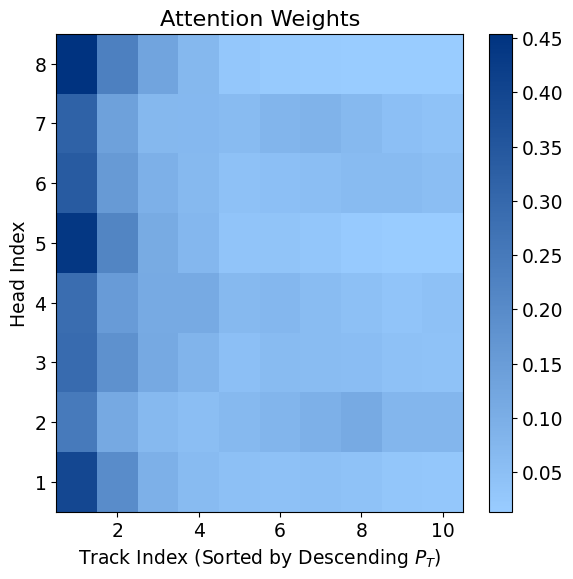

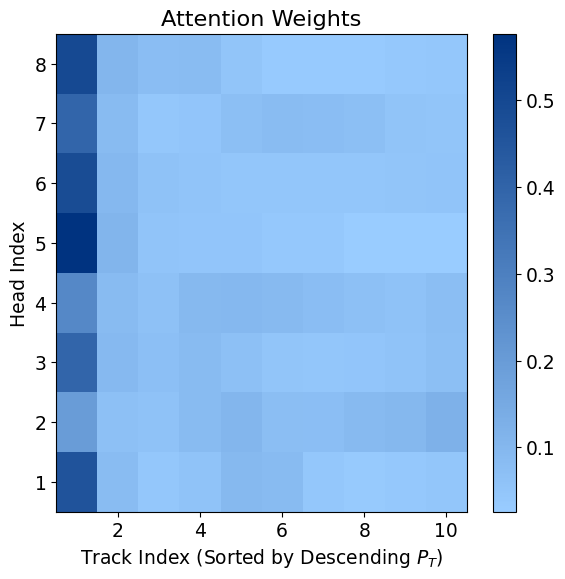

In [18]:
plot_weight(trk_score_8_10)
plot_weight(qtrk_score_8_10)

In [19]:
trk_score_trk = tf.reduce_mean(trk_score_per_head, axis=0)
twr_score_twr = tf.reduce_mean(twr_score_per_head, axis=0)

qtrk_score_trk = tf.reduce_mean(qtrk_score_per_head, axis=0)
qtwr_score_twr = tf.reduce_mean(qtwr_score_per_head, axis=0)

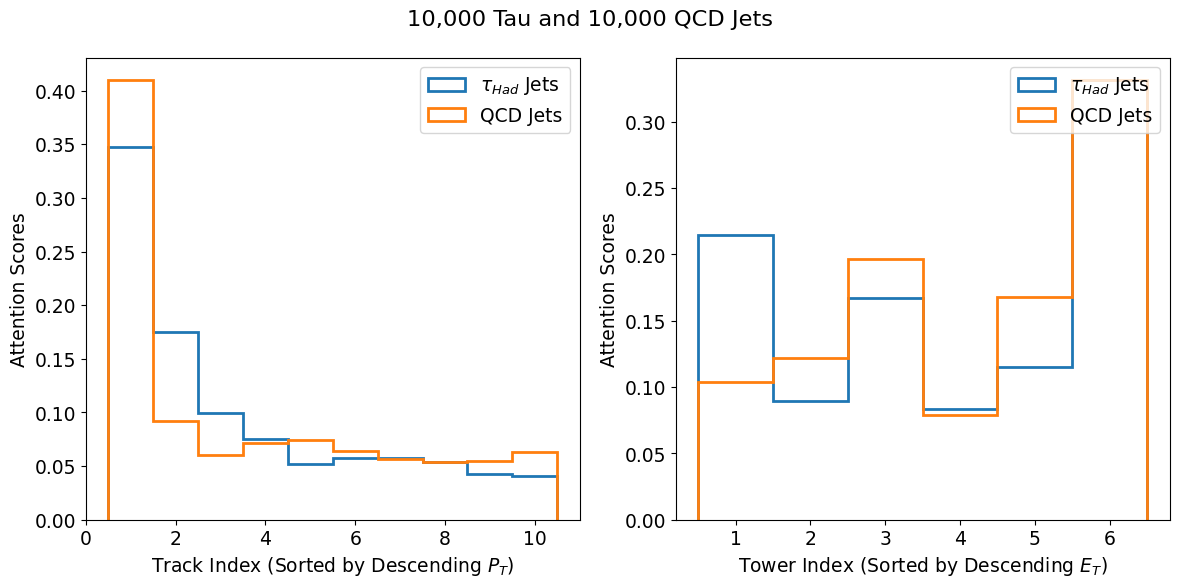

In [20]:
plot_hist([[trk_score_trk, qtrk_score_trk], [twr_score_twr, qtwr_score_twr]])

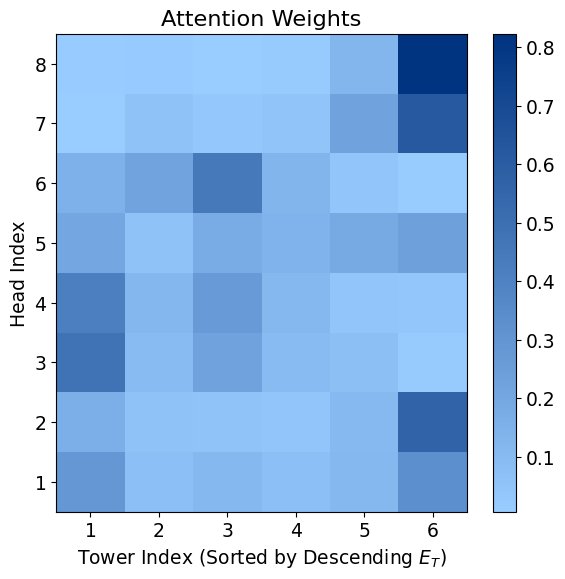

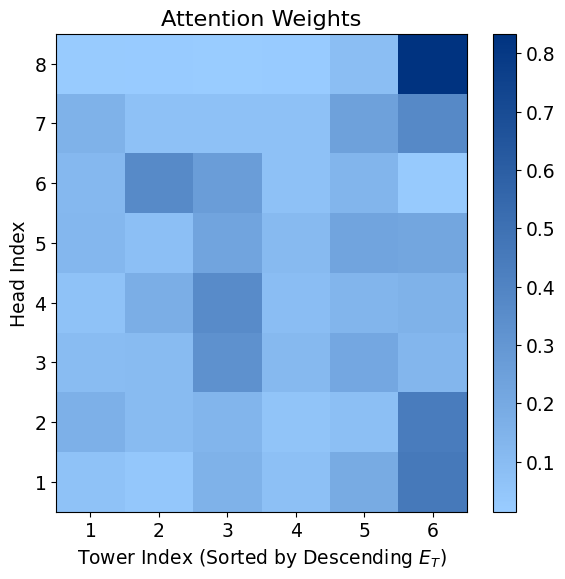

In [21]:
plot_weight(twr_score_8_6)
plot_weight(qtwr_score_8_6)

In [22]:
def plot_scatter(all_weights, all_errors):
    plt.rcParams['font.size'] = '13.5'
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for i in range(2):
        weights = all_weights[i]
        len_x = len(weights[0])
        if len_x > 7:
            x_label = r"Track Index (Sorted by Descending $P_T$)"
        else:
            x_label = r"Tower Index (Sorted by Descending $E_T$)"
        x = list(range(1, len_x+1))
        rg = (0.5, len_x+0.5)
        n_bins = len_x
        ax[i].hist(x, range=rg, bins=n_bins, weights=weights[0], align='mid', label=r'$\tau_{Had}$ Jets', histtype='step', lw=2)
        ax[i].hist(x, range=rg, bins=n_bins, weights=weights[1], align='mid', label=r'QCD Jets', histtype='step', lw=2)
        ax[i].set_ylabel('Attention Scores')
        ax[i].set_xlabel(x_label)
        ax[i].legend()
    fig.suptitle('10,000 Tau and 10,000 QCD Jets')
    plt.tight_layout()
    #plt.savefig('Attention_Scores.pdf')
    plt.show()

In [37]:
trk_score_to_plot = tf.reduce_mean(trk_score, axis=[1,2])
qtrk_score_to_plot = tf.reduce_mean(qtrk_score, axis=[1,2])

In [46]:
original_data = zip(data['track_info'][:len_data],data['cluster_info'][:len_data],data['hlv_info'][:len_data])
original_qcd = zip(qcd['track_info'][:len_data],qcd['cluster_info'][:len_data],qcd['hlv_info'][:len_data])

In [47]:
trk_pt, trk_eta, trk_phi, trk_dis = [], [], [], []
for jet in original_data:
    tracks = jet[0]
    jet_info = jet[2]
    jet_eta, jet_phi = jet_info[1], jet_info[2]
    all_dr = []
    for trk in tracks:
        pt, eta, phi = trk[1], trk[2], trk[3]
        dR = np.sqrt(phi**2 + eta**2)
        trk_pt.append(pt)
        trk_eta.append(eta)
        trk_phi.append(phi)
        all_dr.append(dR)
    trk_dis.append(all_dr)

qtrk_pt, qtrk_eta, qtrk_phi, qtrk_dis = [], [], [], []
for jet in original_qcd:
    tracks = jet[0]
    jet_info = jet[2]
    jet_eta, jet_phi = jet_info[1], jet_info[2]
    all_dr = []
    for trk in tracks:
        pt, eta, phi = trk[1], trk[2], trk[3]
        dR = np.sqrt(phi**2 + eta**2)
        qtrk_pt.append(pt)
        qtrk_eta.append(eta)
        qtrk_phi.append(phi)
        all_dr.append(dR)
    qtrk_dis.append(all_dr)

In [49]:
trk_std = tf.math.reduce_std(trk_score_to_plot, axis=0)
dis_mean, dis_std = tf.reduce_mean(trk_dis, axis=0), tf.math.reduce_std(trk_dis, axis=0)
flat_trk_score = tf.reshape(trk_score_to_plot, shape=[10000*10])

qtrk_std = tf.math.reduce_std(qtrk_score_to_plot, axis=0)
qdis_mean, qdis_std = tf.reduce_mean(qtrk_dis, axis=0), tf.math.reduce_std(qtrk_dis, axis=0)
qflat_trk_score = tf.reshape(qtrk_score_to_plot, shape=[10000*10])

In [51]:
twr_score_to_plot = tf.reduce_mean(twr_score, axis=[1,2])
original_data = zip(data['track_info'][:len_data],data['cluster_info'][:len_data],data['hlv_info'][:len_data])
twr_et, twr_eta, twr_phi, twr_dis = [], [], [], []
for jet in original_data:
    towers = jet[1]
    jet_info = jet[2]
    jet_eta, jet_phi = jet_info[1], jet_info[2]
    all_dr = []
    for twr in towers:
        et, eta, phi = twr[1], twr[2], twr[3]
        dR = np.sqrt(phi**2 + eta**2)
        twr_et.append(et)
        twr_eta.append(eta)
        twr_phi.append(phi)
        all_dr.append(dR)
    twr_dis.append(all_dr)
twr_std = tf.math.reduce_std(twr_score_to_plot, axis=0)
tdis_mean, tdis_std = tf.reduce_mean(twr_dis, axis=0), tf.math.reduce_std(twr_dis, axis=0)
flat_twr_score = tf.reshape(twr_score_to_plot, shape=[10000*6])

qtwr_score_to_plot = tf.reduce_mean(qtwr_score, axis=[1,2])
original_qcd = zip(qcd['track_info'][:len_data],qcd['cluster_info'][:len_data],qcd['hlv_info'][:len_data])
qtwr_et, qtwr_eta, qtwr_phi, qtwr_dis = [], [], [], []
for jet in original_qcd:
    towers = jet[1]
    jet_info = jet[2]
    jet_eta, jet_phi = jet_info[1], jet_info[2]
    all_dr = []
    for twr in towers:
        et, eta, phi = twr[1], twr[2], twr[3]
        dR = np.sqrt(phi**2 + eta**2)
        qtwr_et.append(et)
        qtwr_eta.append(eta)
        qtwr_phi.append(phi)
        all_dr.append(dR)
    qtwr_dis.append(all_dr)
qtwr_std = tf.math.reduce_std(qtwr_score_to_plot, axis=0)
qtdis_mean, qtdis_std = tf.reduce_mean(qtwr_dis, axis=0), tf.math.reduce_std(qtwr_dis, axis=0)
qflat_twr_score = tf.reshape(qtwr_score_to_plot, shape=[10000*6])

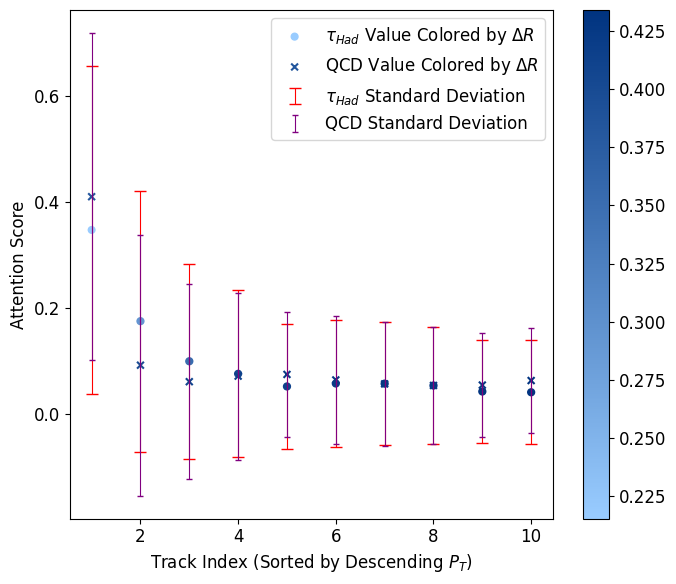

In [69]:
plt.rcParams['font.size'] = '12'
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))
ax = plt.gca()
fig = plt.gcf()
colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)
for i in range(1):
    weights = trk_score_trk
    len_x = 10
    if len_x > 7:
        x_label = r"Track Index (Sorted by Descending $P_T$)"
    else:
        x_label = r"Tower Index (Sorted by Descending $E_T$)"
    x = list(range(1, len_x+1))
    rg = (0.5, len_x+0.5)
    #n_bins = len_x
    #ax[i].hist(x, range=rg, bins=n_bins, weights=weights[0], align='mid', label=r'$\tau_{Had}$ Jets', histtype='step', lw=2)
    #ax[i].hist(x, range=rg, bins=n_bins, weights=weights[1], align='mid', label=r'QCD Jets', histtype='step', lw=2)
    mini = min(tf.reduce_min(dis_mean), tf.reduce_min(qdis_mean))
    maxi = max(tf.reduce_max(dis_mean), tf.reduce_max(qdis_mean))
    norm = plt.Normalize(mini, maxi)

    #ax[i].scatter(x, dis_mean, marker ='o', norm=norm, s=trk_std*5000, c=trk_score_trk, cmap=cm)
    #ax[i].errorbar(x, dis_mean, yerr=dis_std)
    
    plt.errorbar(x, trk_score_trk, fmt='none', yerr=trk_std, capsize=4, ecolor='r', elinewidth=0.8, label=r'$\tau_{Had}$ Standard Deviation')
    plt.scatter(x, trk_score_trk, marker ='o', norm=norm, s=np.exp(dis_std)*20, c=dis_mean, cmap=cm, label=r'$\tau_{Had}$ Value Colored by $\Delta R$')
    plt.errorbar(x, qtrk_score_trk, fmt='none', yerr=trk_std, capsize=2, ecolor='purple', elinewidth=0.8, label='QCD Standard Deviation')
    plt.scatter(x, qtrk_score_trk, marker ='x', norm=norm, s=np.exp(qdis_std)*20, c=qdis_mean, cmap=cm, label='QCD Value Colored by $\Delta R$')
    ax.set_ylabel('Attention Score')
    ax.set_xlabel(x_label)
    ax.legend()
#fig.suptitle('10,000 Tau and 10,000 QCD Jets')
plt.tight_layout()
plt.colorbar(ax = ax)
plt.savefig('Attention_Track_Scores.pdf')
plt.show()

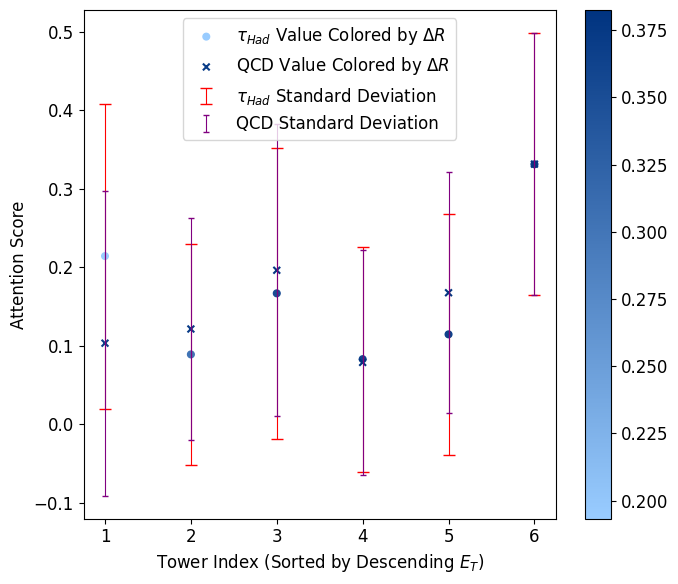

In [60]:
plt.rcParams['font.size'] = '12'
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))
ax = plt.gca()
fig = plt.gcf()
colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)

weights = twr_score_twr

x_label = r"Tower Index (Sorted by Descending $E_T$)"
x = list(range(1, 7))
plt.errorbar(x, twr_score_twr, fmt='none', yerr=twr_std, capsize=4, ecolor='r', elinewidth=0.8, label=r'$\tau_{Had}$ Standard Deviation')
plt.scatter(x, twr_score_twr, marker ='o', norm=norm, s=np.exp(tdis_std)*20, c=tdis_mean, cmap=cm, label=r'$\tau_{Had}$ Value Colored by $\Delta R$')
plt.errorbar(x, qtwr_score_twr, fmt='none', yerr=twr_std, capsize=2, ecolor='purple', elinewidth=0.8, label='QCD Standard Deviation')
plt.scatter(x, qtwr_score_twr, marker ='x', norm=norm, s=np.exp(qtdis_std)*20, c=qtdis_mean, cmap=cm, label='QCD Value Colored by $\Delta R$')
ax.set_ylabel('Attention Score')
ax.set_xlabel(x_label)
ax.legend()
#fig.suptitle('10,000 Tau and 10,000 QCD Jets')
plt.tight_layout()
plt.colorbar(ax = ax)
plt.savefig('Attention_Tower_Scores.pdf')
plt.show()

In [30]:
def plot_jet_rings(jet_eta,jet_phi,tau_tagged):
    """
    Function for graphing circles displaying the core (R=0.1), central (R=0.2) and outer (R=0.4) regions of the jet
    """
    theta = np.linspace(0, 2*np.pi, 100)
    radius_core = 0.1
    a_core = radius_core*np.cos(theta) + jet_eta
    b_core = radius_core*np.sin(theta) + jet_phi

    radius_cent = 0.2
    a_cent = radius_cent*np.cos(theta) + jet_eta
    b_cent = radius_cent*np.sin(theta) + jet_phi

    radius_out = 0.4
    a_out = radius_out*np.cos(theta) + jet_eta
    b_out = radius_out*np.sin(theta) + jet_phi
    if tau_tagged == 0: 
        plt.plot(a_core, b_core, 'r')
        plt.plot(a_cent, b_cent, 'r')
        plt.plot(a_out, b_out, 'r')
        plt.plot(jet_eta, jet_phi, 'r')
    else:
        plt.plot(a_core, b_core, 'y')
        plt.plot(a_cent, b_cent, 'y')
        plt.plot(a_out, b_out, 'y')
        plt.plot(jet_eta, jet_phi, 'y')

def plot_jet_rings_first_q(jet_eta,jet_phi,tau_tagged):
    """
    Function for graphing circles displaying the core (R=0.1), central (R=0.2) and outer (R=0.4) regions of the jet
    """
    theta = np.linspace(0, np.pi/2, 100)
    radius_core = 0.1
    a_core = radius_core*np.cos(theta) + jet_eta
    b_core = radius_core*np.sin(theta) + jet_phi

    radius_cent = 0.2
    a_cent = radius_cent*np.cos(theta) + jet_eta
    b_cent = radius_cent*np.sin(theta) + jet_phi

    radius_out = 0.4
    a_out = radius_out*np.cos(theta) + jet_eta
    b_out = radius_out*np.sin(theta) + jet_phi
    if tau_tagged == 0: 
        plt.plot(a_core, b_core, 'r')
        plt.plot(a_cent, b_cent, 'r')
        plt.plot(a_out, b_out, 'r')
        plt.plot(jet_eta, jet_phi, 'r')
    else:
        plt.plot(a_core, b_core, 'y')
        plt.plot(a_cent, b_cent, 'y')
        plt.plot(a_out, b_out, 'y')
        plt.plot(jet_eta, jet_phi, 'y')

        
def evt_display(filename,  evt_id, title, output, jet_idxs = 'None', save_fig=True):
    '''
    filename: root ntuple with jet data
    evt_id: which event you want to display
    title: title of graph
    output: file destination to save display
    jet_idxs: optional argument for which jets in event to display
    '''
    tree_name = "output"
    chain = ROOT.TChain(tree_name, tree_name) 
    chain.Add(filename)
    chain.GetEntry(evt_id)
    ax = plt.gca() #you first need to get the axis handle
    ax.set_aspect(1)
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    if jet_idxs == 'None':
        pt = list(chain.TowerEt) + list(chain.TrackPt)
        mini, maxi = min(pt), max(pt)
        norm = plt.Normalize(mini, maxi)
        cm = plt.cm.get_cmap('Blues_r')
        plt.scatter(chain.TowerEta,chain.TowerPhi, linewidths = 0.1, s=36, norm=norm, c=chain.TowerEt, cmap=cm, label = 'towers')
        plt.scatter( chain.TrackEta,chain.TrackPhi, marker = 'x', s=36,norm=norm, c=chain.TrackPt, cmap=cm, label = 'tracks')
        
        tower_phi = []
        tower_eta = []
        track_phi = []
        track_eta = []
        last_tower_idx = 0 
        last_track_idx = 0 #keeps track of last final index for tracks and towers
        #this for loop splits up all of the tower/track phi and eta data into different lists for each jet, compiles together as list of lists
        for jet_id in range(chain.nJets):
            plot_jet_rings(chain.JetEta[jet_id],chain.JetPhi[jet_id], chain.TruthJetIsTautagged[jet_id])
        plt.title(title)
        plt.xlabel('Pseudorapiditiy ($\eta$)',fontsize = 16)
        plt.ylabel('Azimuthal angle ($\phi$)', fontsize = 16)
        plt.colorbar(ax = ax, shrink = 0.5)
        plt.tight_layout()
        plt.savefig(output)
        plt.show()
        
    else:
        tower_phi = []
        tower_eta = []
        tower_Et = []
        track_phi = []
        track_eta = []
        track_pt = []
        last_tower_idx = 0 
        last_track_idx = 0 #keeps track of last final index for tracks and towers
        #this for loop splits up all of the tower/track phi and eta data into different lists for each jet, compiles together as list of lists
        for jet_id in range(chain.nJets):
            jet_tower_n = chain.JetTowerN[jet_id]
            tower_phi.append(chain.JetTowerPhi[last_tower_idx:last_tower_idx+jet_tower_n])
            tower_eta.append(chain.JetTowerEta[last_tower_idx:last_tower_idx+jet_tower_n])
            tower_Et.append(chain.JetTowerEt[last_tower_idx:last_tower_idx+jet_tower_n])
            last_tower_idx += jet_tower_n

            jet_track_n = chain.JetGhostTrackN[jet_id]
            jet_track_idxs = chain.JetGhostTrackIdx[last_track_idx:last_track_idx+jet_track_n]

            jet_track_eta = []
            jet_track_phi = []
            jet_track_pt = []
            for jet_track_idx in jet_track_idxs:
                jet_track_eta.append(chain.TrackEta[jet_track_idx])
                jet_track_phi.append(chain.TrackPhi[jet_track_idx])
                jet_track_pt.append(chain.TrackPt[jet_track_idx])
            track_eta.append(jet_track_eta)
            track_phi.append(jet_track_phi)
            track_pt.append(jet_track_pt)
            last_track_idx += jet_track_n

        colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
        cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)
        #now, looks at each jet_idx given to function on plots that jet and it's associated towers and tracks
        for jet_idx in jet_idxs:
            plot_jet_rings(chain.JetEta[jet_idx],chain.JetPhi[jet_idx], chain.TruthJetIsTautagged[jet_idx])
            
            pt = list(tower_Et[jet_idx]) + list(track_pt[jet_idx])
            mini, maxi = min(pt), max(pt)
            norm = plt.Normalize(mini, maxi)
            plt.scatter(tower_eta[jet_idx],tower_phi[jet_idx],  marker ='o', linewidths = 0.5, s=36, norm=norm, c=tower_Et[jet_idx], cmap=cm, label = 'towers')
            plt.scatter(track_eta[jet_idx],track_phi[jet_idx],   marker ='x', norm=norm, s=36, c=track_pt[jet_idx], cmap=cm, label = 'tracks')

        #finishes plotting the graph
        plt.title(title, fontsize = 16)
        plt.xlabel('Pseudorapiditiy ($\eta$)',fontsize = 16)
        plt.ylabel('Azimuthal angle ($\phi$)', fontsize = 16)
        plt.colorbar(ax = ax, shrink = 0.5)
        plt.tight_layout()
        plt.legend()
        if save_fig:
            plt.savefig(output)
        plt.show()

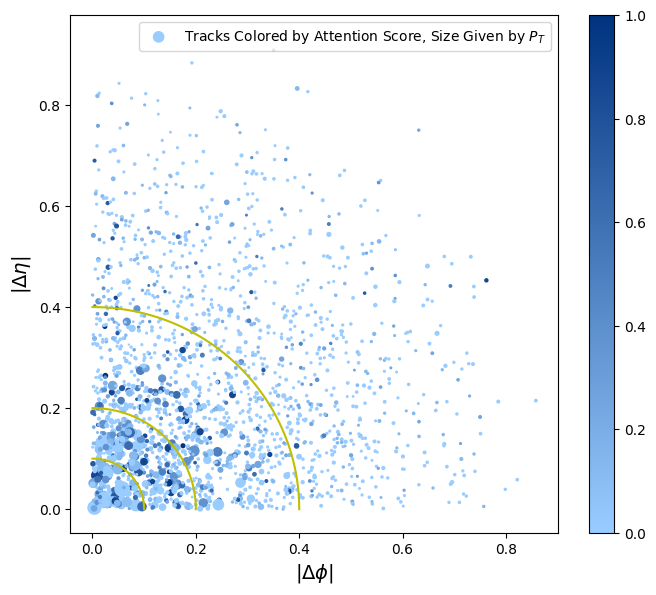

In [61]:
plt.rcParams['font.size'] = '10'
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))
ax = plt.gca()
fig = plt.gcf()
colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)
#plot_jet_rings(0,0,1)
plot_jet_rings_first_q(0,0,1)
n = 200
weights = flat_trk_score[:10*n]
#weights = np.concatenate(trk_dis)[:1000]
mini, maxi = min(weights), max(weights)
norm = plt.Normalize(mini, maxi)
#norm=None
plt.scatter(trk_eta[:10*n], trk_phi[:10*n], marker ='o', norm=norm, s=10**np.array(trk_pt[:10*n]), c=weights, cmap=cm, label = 'Tracks Colored by Attention Score, Size Given by $P_T$')

ax.set_ylabel(r'$|\Delta\eta|$', fontsize = 14)
ax.set_xlabel(r'$|\Delta\phi|$', fontsize = 14)
ax.legend()
#fig.suptitle('10,000 Tau and 10,000 QCD Jets')
plt.tight_layout()
plt.colorbar(ax = ax)
plt.savefig('Track_Scores_Plot.pdf')
plt.show()

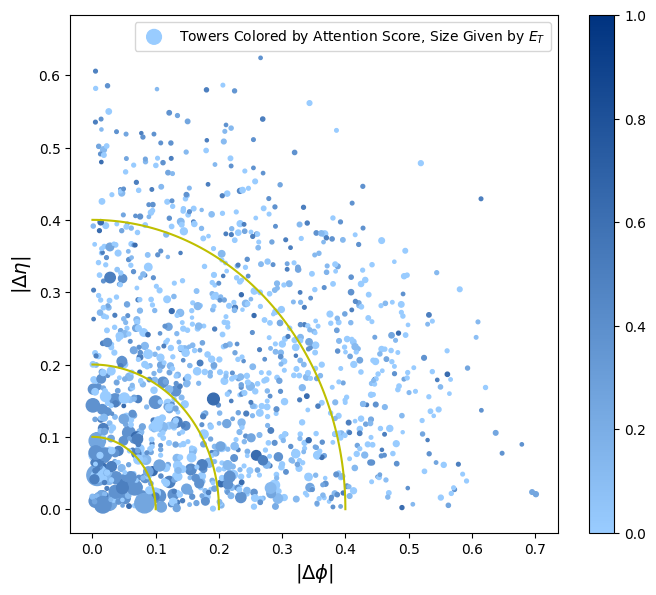

In [62]:
plt.rcParams['font.size'] = '10'
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))
ax = plt.gca()
fig = plt.gcf()
colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)
#plot_jet_rings(0,0,1)
plot_jet_rings_first_q(0,0,1)
n = 200
weights = flat_twr_score[:6*n]
#weights = np.concatenate(trk_dis)[:1000]
#mini, maxi = min(weights), max(weights)
#norm = plt.Normalize(mini, maxi)
#norm=None
plt.scatter(twr_eta[:6*n], twr_phi[:6*n], marker ='o', norm=norm, s=10**np.array(twr_et[:6*n]), c=weights, cmap=cm, label = 'Towers Colored by Attention Score, Size Given by $E_T$')

ax.set_ylabel(r'$|\Delta\eta|$', fontsize = 14)
ax.set_xlabel(r'$|\Delta\phi|$', fontsize = 14)
ax.legend()
#fig.suptitle('10,000 Tau and 10,000 QCD Jets')
plt.tight_layout()
plt.colorbar(ax = ax)
plt.savefig('Tower_Scores_Plot.pdf')
plt.show()